# Coding and evaluating a breakout signal

Based on mean reversion theory, when stocks break out of the normal low and high range, we take advantage by taking long positions on stocks below low range and/or short position on stocks above high range. 


In [1]:
import pandas as pd
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
%matplotlib inline

### Load data

In [3]:
files = glob.glob("/home/home/vbox_shared/projects/Breakout-Strategy/daily/*.csv")
df = pd.concat([pd.read_csv(fp, names=['date','0','open','high','low','close','volume'])
        .assign(ticker=os.path.basename(fp).replace('_','.').split('.')[1]) for fp in files])
df['date'] = pd.to_datetime(df['date'],format='%Y%m%d')

In [4]:
close = df.reset_index().pivot(index='date', columns='ticker',values='close')
high = df.reset_index().pivot(index='date',columns='ticker',values='high')
low = df.reset_index().pivot(index='date', columns='ticker',values='low')

### Plot sample ticker

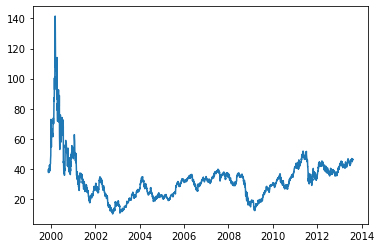

In [5]:
plt.plot(close['a'])

### Define hypothesis


- In the absence of news or significant investor trading interest, stocks oscillate in a range.
- Traders seek to capitalize on this range-bound behaviour periodically by selling/shorting at the top of the range and buying/covering at the bottom of the range. This behaviour reinforces the existence of the range.
- When stocks break out of the range, due to, e.g., a significant news release or from market pressure from a large investor:
    - the liquidity traders who have been providing liquidity at the bounds of the range seek to cover their positions to mitigate losses, thus magnifying the move out of the range, and
    - the move out of the range attracts other investor interest; these investors, due to the behavioural bias of herding (e.g., Herd Behavior) build positions which favor continuation of the trend.


### Compute highs and lows in a window

In [6]:
def get_high_lows_lookback(high, low, lookback_days):
    """
    Get maximum high price and minimum low price over a window of days. Make sure not to include current day.
    """
    
    lb_high = high.shift(1).rolling(window=lookback_days).max()
    lb_low = low.shift(1).rolling(window=lookback_days).min()
    
    return lb_high, lb_low
    

In [7]:
lookback_high, lookback_low = get_high_lows_lookback(high,low,50)

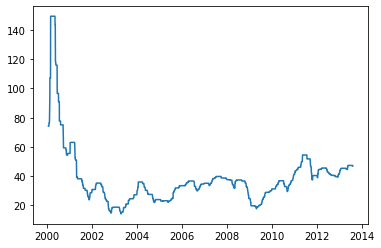

In [8]:
# plot data

plt.plot(lookback_high['a'])

### Compute long and short signals

-1 for low > close, 1 for high < close and 0 otherwise

In [9]:
def get_long_short(close, lookback_high, lookback_low):
    
#     signal = pd.DataFrame(0, index=close.index, columns=close.columns)
#     for ticker, row in signal.iteritems():
#         for dt, val in row.iteritems():
#             if lookback_high.loc[dt][ticker] < close.loc[dt][ticker]:
#                 signal.loc[dt][ticker] = 1
#             if lookback_low.loc[dt][ticker] > close.loc[dt][ticker]:
#                 signal.loc[dt][ticker] = -1

    signal = ((close < lookback_low).astype(int) * -1) + (close > lookback_high).astype(int)
    
    return signal

In [17]:
signals = get_long_short(close, lookback_high, lookback_low)

### Filter redundant signals

If we're already shorting a stock, having an additional signal to short a stock isn't helpful for this strategy. This also applies to additional long signals when the last signal was long.

Implement filter_signals to filter out repeated long or short signals within the lookahead_days. If the previous signal was the same, change the signal to 0 (do nothing signal). For example, say you have a single stock time series that is

`[1, 0, 1, 0, 1, 0, -1, -1]`

Running filter_signals with a lookahead of 3 days should turn those signals into

`[1, 0, 0, 0, 1, 0, -1, 0]`

To help you implement the function, we have provided you with the clear_signals function. This will remove all signals within a window after the last signal. For example, say you're using a windows size of 3 with clear_signals. It would turn the Series of long signals

`[0, 1, 0, 0, 1, 1, 0, 1, 0]`

into

`[0, 1, 0, 0, 0, 1, 0, 0, 0]`

clear_signals only takes a Series of the same type of signals, where 1 is the signal and 0 is no signal. It can't take a mix of long and short signals. Using this function, implement filter_signals.

For implementing filter_signals, we don't reccommend you try to find a vectorized solution. Instead, you should use the iterrows over each column.

In [11]:
def clear_signals(signals, window_size):
    """
    Remove the number of signals to 1 withing the window size time period.
    """
    
    clean_signals = [0] * window_size #start w/ buffer of window size to handle edge case of calc. past_signal@ beg
    
    for signal_i, current_signal in enumerate(signals):
        has_past_signal = bool(sum(clean_signals[signal_i:signal_i+window_size]))
        clean_signals.append(not has_past_signal and current_signal)
        
    clean_signals = clean_signals[window_size:]
    
    return pd.Series(np.array(clean_signals).astype(np.int), signals.index)

In [12]:
def filter_signals(signal, lookahead_days):
    pos_signal = signal[signal ==1].fillna(0)
    neg_signal = signal[signal==-1].fillna(0) * -1
    
    pos_signal = pos_signal.apply(lambda signals: clear_signals(signals, lookahead_days))
    neg_signal = neg_signal.apply(lambda signals: clear_signals(signals, lookahead_days))
    
    return pos_signal + neg_signal*-1

In [18]:
lookahead_days = 3
#signals = [1, 0, 1, 0, 1, 0, -1, -1]
#signals = pd.DataFrame(signals)
filter_signals(signals,3)

ticker,a,aa,aapl,abbv,abc,abt,ace,acn,act,adbe,...,xl,xlnx,xom,xray,xrx,xyl,yhoo,yum,zion,zmh
date,,,,,,,,,,,,,,,,,,,,,
1998-01-02,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1998-01-05,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1998-01-06,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1998-01-07,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1998-01-08,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-08-05,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2013-08-06,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2013-08-07,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Lookahead Close Prices

Evaluating how many days to short or long the stocks - Implement `get_lookahead_prices` to get the close price days ahead in time. You can get the number of days from the variable `lookahead_days`. We'll use the lookahead prices to calculate future returns in another problem.

In [19]:
def get_lookahead_prices(close, lookahead_days):
    """
    Get the lookahead prices for `lookahead_days` number of days.
    
    """
    return close.shift(-lookahead_days)

### Lookahead Price Returns

Implement `get_return_lookahead` to generate the log price return between the closing price and the lookahead price.


In [20]:
def get_return_lookahead(close, lookahead_prices):
    """
    Calculate the log returns from the lookahead days to the signal day.
    """

    return  np.log(lookahead_prices) - np.log(close) 

In [21]:
lookahead_prices = get_lookahead_prices(close, lookahead_days)
lookahead_return = get_return_lookahead(close, lookahead_prices)

### Compute the Signal Return

Using the price returns generate the signal returns.


In [22]:
def get_signal_return(signal, lookahead_returns):
    """
    Compute the signal returns.
    """ 
    return lookahead_returns*signal

In [29]:
signal_returns = get_signal_return(signals,lookahead_return)
signal_returns

ticker,a,aa,aapl,abbv,abc,abt,ace,acn,act,adbe,...,xl,xlnx,xom,xray,xrx,xyl,yhoo,yum,zion,zmh
date,,,,,,,,,,,,,,,,,,,,,
1998-01-02,NaN,-0.0,0.000000,NaN,-0.0,-0.0,0.0,NaN,0.0,0.0,...,-0.0,-0.0,-0.0,-0.0,-0.000000,NaN,-0.0,-0.000000,-0.0,NaN
1998-01-05,NaN,-0.0,0.000000,NaN,-0.0,0.0,-0.0,NaN,-0.0,0.0,...,-0.0,-0.0,-0.0,-0.0,-0.000000,NaN,0.0,-0.000000,-0.0,NaN
1998-01-06,NaN,-0.0,-0.000000,NaN,-0.0,0.0,-0.0,NaN,-0.0,-0.0,...,-0.0,-0.0,-0.0,-0.0,-0.000000,NaN,-0.0,-0.000000,-0.0,NaN
1998-01-07,NaN,-0.0,0.000000,NaN,-0.0,0.0,-0.0,NaN,-0.0,-0.0,...,-0.0,-0.0,-0.0,-0.0,-0.000000,NaN,-0.0,-0.000000,-0.0,NaN
1998-01-08,NaN,-0.0,0.000000,NaN,-0.0,0.0,0.0,NaN,-0.0,-0.0,...,-0.0,0.0,0.0,-0.0,-0.000000,NaN,0.0,0.000000,-0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-08-05,-0.0,-0.0,-0.010962,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,...,-0.0,-0.0,0.0,0.0,-0.008978,-0.0,-0.0,-0.009135,-0.0,-0.0
2013-08-06,0.0,0.0,-0.000000,-0.0,0.0,-0.0,-0.0,0.0,-0.0,-0.0,...,-0.0,-0.0,-0.0,0.0,0.000000,-0.0,0.0,0.000000,0.0,-0.0
2013-08-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [49]:
# Filter out returns that don't have a long or short signal.
long_short_signal_returns = signal_returns[signals != 0].stack()
long_short_signal_returns.columns = ['signal_return']
long_short_signal_returns

date        ticker
1998-03-17  act      -0.007811
            aes       0.012417
            afl      -0.000915
            aig       0.005842
            an       -0.037902
                        ...   
2013-08-06  pnr       0.003633
            tap      -0.001314
            trip      0.020609
            tsn       0.021271
            wpo      -0.015209
Length: 139714, dtype: float64

## Test for Significance

### Histogram

### Outliers

### Kolmogorov-Smirnov Test

In [96]:
from scipy.stats import kstest


def calculate_kstest(long_short_signal_returns):
    """
    Calculate the KS-Test against the signal returns with a long or short signal.
 
    """
    
    #ret = long_short_signal_returns.groupby(['ticker'])
    test_ser = pd.DataFrame()
    mean = long_short_signal_returns.mean()
    std = long_short_signal_returns.std(ddof=0)
    
    test_ser[long_short_signal_returns.index[1]] = kstest(long_short_signal_returns,'norm',args=(mean,std))
    #print(kstest(ret,'norm'))
    #ks = kstest()
    print(test_ser.T)
    ks = test_ser.T[0]
    p = test_ser.T[1]
    return ks, p

In [97]:
ks,p = calculate_kstest(long_short_signal_returns)
print(ks)

                                   0    1
(1998-03-17 00:00:00, aes)  0.113363  0.0
                                   0    1
(1998-03-17 00:00:00, aes)  0.113363  0.0


### Find Outliers

With the ks and p values calculate, let's find which symbols are the outliers. Implement the find_outliers function to find the following outliers:

    Symbols that pass the null hypothesis with a p-value less than pvalue_threshold.
    Symbols that with a KS value above ks_threshold.



In [87]:
def find_outliers(ks_values, p_values, ks_threshold, pvalue_threshold=0.05):
    
    p_thres = p_values[p_values < pvalue_threshold].tolist()
    ks_thres = ks_values[ks_values > ks_threshold].tolist()
    print(p_thres)
    lst = set(p_thres)&set(ks_thres)

    return lst

### Show Significance without Outliers

In [88]:
outlier_tickers = find_outliers(ks.values[0], p.values[0], ks_threshold=0.8, pvalue_threshold=0.05)
without_outliers = list(set(close.columns) - outlier_tickers)

[0.0]


In [85]:
outlier_tickers

set()

In [86]:
without_outliers

['gis',
 'key',
 'rok',
 'ltd',
 'fisv',
 'pom',
 'jcp',
 'nwsa',
 'd',
 'px',
 'isrg',
 'rhi',
 'wag',
 'ph',
 'amd',
 'hcn',
 'iff',
 'ntap',
 'aapl',
 'mnst',
 'aiv',
 'gps',
 'pvh',
 'mon',
 'dnr',
 'txt',
 'gas',
 'vtr',
 'c',
 'mdt',
 'pnw',
 'pld',
 'rsg',
 'noc',
 'swy',
 'tap',
 'mcd',
 'fitb',
 'cma',
 'pcp',
 'pbct',
 'blk',
 'nwl',
 'col',
 'xray',
 'cam',
 'coh',
 'sbux',
 'v',
 'an',
 'r',
 'mck',
 'mmm',
 'arg',
 'rht',
 'ea',
 'mmc',
 'pcg',
 'clx',
 'cce',
 'hes',
 'hot',
 'ibm',
 'f',
 'mrk',
 'abt',
 'hog',
 'ed',
 'ecl',
 'viab',
 'ca',
 'mkc',
 'cpb',
 'lo',
 'dow',
 'cb',
 'wdc',
 'anf',
 'csx',
 'chk',
 'amp',
 'cost',
 'has',
 'chrw',
 'esv',
 'pdco',
 'hrs',
 'mos',
 'sni',
 'nrg',
 'rrc',
 'cinf',
 'nbr',
 'hon',
 'altr',
 'petm',
 'fcx',
 'cah',
 'lltc',
 'mro',
 'orly',
 'mur',
 'spg',
 'm',
 'fast',
 'teg',
 'cci',
 'bmc',
 'lsi',
 'do',
 'molx',
 'bxp',
 'twc',
 'scg',
 'biib',
 'te',
 'gme',
 'ci',
 'xl',
 'krft',
 'eog',
 'tgt',
 'dhr',
 'syy',
 'mco',
 